In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
#     print(iterations_to_analyze) # check that this is giving me the last avail iteration
#     for step in iterations_to_analyze: 
#         analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
#         f_ij, df_ij = analyzer.get_free_energy()
#         dg.append(f_ij[0,-1])
#         ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 5 ns N501Y (repex/32/0/0)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 32
sub_dir = 0
chunk = 0
titles = ['N501Y']

In [7]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [8]:
f_ij.shape

(12, 12)

In [9]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


0 complex: 30.317589404378072 (0.025186798152782772) kT



In [6]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/1)

In [7]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [8]:
main_dir = 32
sub_dir = 0
chunk = 1
titles = ['N501Y']

In [13]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [14]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


1 complex: 33.78609546609796 (0.0324260555838558) kT



In [9]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/2)

In [10]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [11]:
main_dir = 32
sub_dir = 0
chunk = 2
titles = ['N501Y']

In [18]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [19]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


2 complex: 33.38106966806233 (0.032094311153868516) kT



In [12]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/3)

In [13]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [14]:
main_dir = 32
sub_dir = 0
chunk = 3
titles = ['N501Y']

In [23]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [24]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


3 complex: 28.83260611686588 (0.02313624896435957) kT



In [15]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/4)

In [16]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [17]:
main_dir = 32
sub_dir = 0
chunk = 4
titles = ['N501Y']

In [28]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [29]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


4 complex: 23.753147120579058 (0.011733386875779638) kT



In [18]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/5)

In [19]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [20]:
main_dir = 32
sub_dir = 0
chunk = 5
titles = ['N501Y']

In [33]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [34]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


5 complex: -3.843213800298707 (0.008393400308161015) kT



In [21]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/6)

In [22]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [23]:
main_dir = 32
sub_dir = 0
chunk = 6
titles = ['N501Y']

In [38]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [39]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


6 complex: -5.528346457830669 (0.00982429523040625) kT



In [24]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/7)

In [25]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [26]:
main_dir = 32
sub_dir = 0
chunk = 7
titles = ['N501Y']

In [43]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [44]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


7 complex: -7.573931047549717 (0.012018729520329488) kT



In [27]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/8)

In [28]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [29]:
main_dir = 32
sub_dir = 0
chunk = 8
titles = ['N501Y']

In [48]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [49]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


8 complex: -8.809337854835654 (0.01468825266755618) kT



In [30]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/0/9)

In [31]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [32]:
main_dir = 32
sub_dir = 0
chunk = 9
titles = ['N501Y']

In [53]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing complex")
complex_path = os.path.join(output_dir, f"{chunk}_complex.nc")
complex_dg, complex_ddg, f_ij, df_ij = analyze_dom(complex_path)

results = np.array([complex_dg, complex_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing complex
n_iterations: 5000


In [54]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    complex_dg, complex_ddg = [result[-1] for result in results]
    print(f"{chunk} complex: {complex_dg} ({complex_ddg}) kT")
    print()


9 complex: -10.116805778106224 (0.014188110915219269) kT



In [33]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_complex.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} complex replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

# Get complex free energy 

In [35]:
chunk_free_energies = []
chunk_errors = []
chunk_matrices = []
for i in range(10):
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{i}/results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        complex_dg, complex_ddg = [result[-1] for result in results]
        chunk_free_energies.append(complex_dg)
        chunk_errors.append(complex_ddg)
        
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{i}/f_ij.npy", "rb") as f:
        f_ij = np.load(f, allow_pickle=True)
        chunk_matrices.append(f_ij)

In [36]:
chunk_free_energies

[30.317589404378072,
 33.78609546609796,
 33.38106966806233,
 28.83260611686588,
 23.753147120579058,
 -3.843213800298707,
 -5.528346457830669,
 -7.573931047549717,
 -8.809337854835654,
 -10.116805778106224]

In [37]:
np.sum(chunk_free_energies)

114.19887283736233

In [38]:
np.sum(chunk_free_energies)*KT_KCALMOL

68.08094593031676

In [39]:
error_sum_squares = 0
for error in chunk_errors:
    error_sum_squares += error**2
np.sqrt(error_sum_squares)*KT_KCALMOL

0.038253352271687316

In [62]:
import matplotlib.pyplot as plt

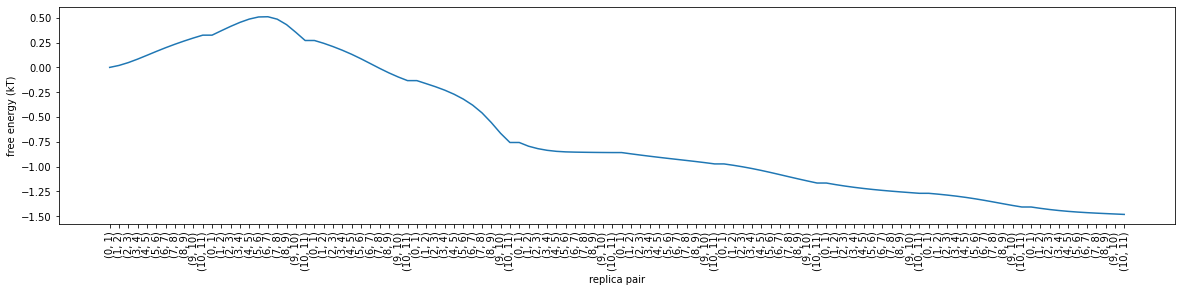

In [126]:
pairs = []
to_plot = []
last_replica_pair_offset = 0
for chunk in range(10):
    first_replica_pair_offset = chunk_matrices[chunk][0][1]
    for replica in range(11):
        pairs.append((replica, replica + 1))
        free_energy = chunk_matrices[chunk][replica][replica+1] - first_replica_pair_offset + last_replica_pair_offset
        to_plot.append(free_energy)
    last_replica_pair_offset = free_energy
plt.figure(figsize=(20, 4))
plt.plot(to_plot)
plt.xlabel('replica pair')
plt.ylabel("free energy (kT)")
plt.xticks(np.arange(110), pairs, rotation=90)  # Set text labels.

plt.show()

In [92]:
len(to_plot)

110

In [103]:
len(pairs)

110

In [116]:
to_plot

[0.0,
 0.019711789656120082,
 0.048291444111758786,
 0.08328150567701442,
 0.12154845224415833,
 0.16042598984139556,
 0.1978750323147329,
 0.23297629897769223,
 0.26572280889333566,
 0.29636496913406685,
 0.3247646320385682,
 0.3247646320385682,
 0.3696734361537901,
 0.41341798290124654,
 0.45356056719886073,
 0.4867752909680645,
 0.5080123918718966,
 0.51021813837247,
 0.48575828496445883,
 0.4308232035964723,
 0.35303693658509605,
 0.2709517136948927,
 -0.05381291834367552,
 -0.08215534681214987,
 -0.11533522935208573,
 -0.15211639407478206,
 -0.19288483345268848,
 -0.23794440538349892,
 -0.2859849268398955,
 -0.3343005984412786,
 -0.37998759746388533,
 -0.42129760731962396,
 -0.45793019496457266,
 -0.40411727662089714,
 -0.4346161458300717,
 -0.46561695769902034,
 -0.5003827589822851,
 -0.5412917553956174,
 -0.5905583650599642,
 -0.6513973261270625,
 -0.7287922791246135,
 -0.8265018808381956,
 -0.9351710094522634,
 -1.027362682125494,
 -0.6232454055045968,
 -0.6606735351435509,
 -0

In [127]:
for i in range(11):
    print((i, i+1), chunk_matrices[0][i][i+1])


(0, 1) 2.596966043771748
(1, 2) 2.616677833427868
(2, 3) 2.645257487883507
(3, 4) 2.6802475494487625
(4, 5) 2.7185144960159064
(5, 6) 2.7573920336131437
(6, 7) 2.794841076086481
(7, 8) 2.8299423427494403
(8, 9) 2.8626888526650838
(9, 10) 2.893331012905815
(10, 11) 2.9217306758103163


In [128]:
for i in range(11):
    print((i, i+1), chunk_matrices[1][i][i+1])


(0, 1) 2.977410349106945
(1, 2) 3.022319153222167
(2, 3) 3.0660636999696234
(3, 4) 3.1062062842672375
(4, 5) 3.1394210080364413
(5, 6) 3.1606581089402734
(6, 7) 3.162863855440847
(7, 8) 3.1384040020328356
(8, 9) 3.083468920664849
(9, 10) 3.005682653653473
(10, 11) 2.9235974307632695


In [129]:
for i in range(11):
    print((i, i+1), chunk_matrices[2][i][i+1])


(0, 1) 3.227534328975458
(1, 2) 3.1991919005069835
(2, 3) 3.1660120179670477
(3, 4) 3.1292308532443514
(4, 5) 3.088462413866445
(5, 6) 3.0434028419356345
(6, 7) 2.995362320479238
(7, 8) 2.947046648877855
(8, 9) 2.901359649855248
(9, 10) 2.8600496399995095
(10, 11) 2.8234170523545608
